In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
import pandas as pd

# Question 01: Basics

In [2]:
# Load datasets
stock_df = pd.read_csv('data/big_tech_stock_prices.csv')
timeline_df = pd.read_csv('data/timeline.csv', delimiter=',', on_bad_lines='skip')

# Convert date columns to datetime
stock_df['date'] = pd.to_datetime(stock_df['date'])

# Filter timeline data to match stock data timeframe (2010-2023)
timeline_df['date'] = pd.to_datetime(timeline_df['date'], format='%Y', errors='coerce')
timeline_df = timeline_df[
    (timeline_df['date'] >= '2010-01-01') & 
    (timeline_df['date'] <= '2023-12-31')
].copy()

# Handle missing values
stock_df = stock_df.dropna(subset=['open', 'high', 'low', 'close'])

stock_symbols = stock_df['stock_symbol'].unique()

In [3]:
def calculate_technical_indicators(data, ma_periods=[20, 50], bb_period=20, bb_std=2):
    """Calculate technical indicators for stock data"""
    indicators = {}
    
    # Calculate Simple Moving Averages
    for period in ma_periods:
        if len(data) >= period:
            indicators[f'SMA_{period}'] = data['close'].rolling(window=period).mean()
    
    # Calculate Exponential Moving Averages
    for period in ma_periods:
        if len(data) >= period:
            indicators[f'EMA_{period}'] = data['close'].ewm(span=period, adjust=False).mean()
    
    # Calculate Bollinger Bands
    if len(data) >= bb_period:
        middle_band = data['close'].rolling(window=bb_period).mean()
        std_dev = data['close'].rolling(window=bb_period).std()
        indicators['BB_middle'] = middle_band
        indicators['BB_upper'] = middle_band + (std_dev * bb_std)
        indicators['BB_lower'] = middle_band - (std_dev * bb_std)
    
    return indicators

In [4]:
def generate_candlestick_chart(symbol, show_sma_20=False, show_sma_50=False, 
                              show_ema_20=False, show_ema_50=False, show_bb=False):
    # Filter stock data for the selected company
    company_data = stock_df[stock_df['stock_symbol'] == symbol]
    
    # Use all available data
    filtered_data = company_data.copy()
    
    indicators = calculate_technical_indicators(filtered_data)
    
    # Create figure with subplots Price and Volume
    fig = make_subplots(
        rows=2, cols=1, 
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3]
    )
    
    # Add candlestick trace for price
    fig.add_trace(
        go.Candlestick(
            x=filtered_data['date'],
            open=filtered_data['open'],
            high=filtered_data['high'],
            low=filtered_data['low'],
            close=filtered_data['close'],
            name=symbol
        ),
        row=1, col=1
    )
    
    # Add 20-day Simple Moving Average
    if show_sma_20 and 'SMA_20' in indicators:
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['SMA_20'],
                line=dict(color='blue', width=1),
                name='SMA 20'
            ),
            row=1, col=1
        )
    
    # Add 50-day Simple Moving Average
    if show_sma_50 and 'SMA_50' in indicators:
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['SMA_50'],
                line=dict(color='purple', width=1),
                name='SMA 50'
            ),
            row=1, col=1
        )
    
    # Add 20-day Exponential Moving Average
    if show_ema_20 and 'EMA_20' in indicators:
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['EMA_20'],
                line=dict(color='green', width=1, dash='dash'),
                name='EMA 20'
            ),
            row=1, col=1
        )
    
    # Add 50-day Exponential Moving Average
    if show_ema_50 and 'EMA_50' in indicators:
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['EMA_50'],
                line=dict(color='magenta', width=1, dash='dash'),
                name='EMA 50'
            ),
            row=1, col=1
        )
    
    # Add Bollinger Bands
    if show_bb and 'BB_middle' in indicators:
        # Add middle band
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['BB_middle'],
                line=dict(color='rgba(125, 125, 125, 0.7)', width=1),
                name='BB Middle'
            ),
            row=1, col=1
        )
        
        # Add upper and lower bands with fill
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['BB_upper'],
                line=dict(color='rgba(125, 125, 125, 0.7)', width=1),
                name='BB Upper',
                showlegend=True
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=filtered_data['date'],
                y=indicators['BB_lower'],
                line=dict(color='rgba(125, 125, 125, 0.7)', width=1),
                name='BB Lower',
                fill='tonexty',
                fillcolor='rgba(125, 125, 125, 0.2)',
                showlegend=True
            ),
            row=1, col=1
        )
    
    # Calculate colors for volume bars based on price direction
    colors = ['rgba(204, 0, 0, 0.7)' if close <= open else 'rgba(0, 153, 51, 0.7)' 
              for close, open in zip(filtered_data['close'], filtered_data['open'])]
    
    # Add volume bar chart with colors
    fig.add_trace(
        go.Bar(
            x=filtered_data['date'],
            y=filtered_data['volume'],
            name='Volume',
            marker_color=colors
        ),
        row=2, col=1
    )
    
    # Filter timeline events for the selected company and time period
    company_events = timeline_df[
        (timeline_df['stock_symbol'] == symbol) & 
        (timeline_df['date'] >= filtered_data['date'].min()) & 
        (timeline_df['date'] <= filtered_data['date'].max())
    ]
    
    shapes = []
    annotations = []
    for _, event in company_events.iterrows():
        shapes.append(dict(
            type='line',
            x0=event['date'],
            x1=event['date'],
            y0=0,
            y1=1,
            xref='x paper',
            yref='paper',
            line=dict(color='red', width=1, dash='dot')
        ))
        annotations.append(dict(
            x=event['date'],
            y=1.0,
            xref='x',
            yref='paper',
            showarrow=True,
            arrowhead=2,
            arrowcolor='red',
            arrowsize=1,
            arrowwidth=1,
            text=event['description'],
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='red',
            borderwidth=1,
            borderpad=4,
            font=dict(size=10)
        ))

    fig.update_layout(
        title=f'{symbol} Stock Price',
        yaxis_title='Price',
        yaxis2_title='Volume',
        xaxis_title='Date',
        shapes=shapes,
        annotations=annotations,
        xaxis_rangeslider_visible=False,
        height=700,
        showlegend=True,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        margin=dict(l=50, r=50, t=85, b=50),
        hovermode='x unified',
        dragmode='zoom',
        selectdirection='h'
    )

    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Volume", row=2, col=1)
    
    return fig

In [5]:
from dash import dcc, html, Input, Output
from jupyter_dash import JupyterDash

# Initialize Dash app
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Big Tech Stock Dashboard"),
    html.Div([
        html.Div([
            html.Label("Company:"),
            dcc.Dropdown(
                id='company-dropdown',
                options=[{'label': symbol, 'value': symbol} for symbol in stock_symbols],
                value=stock_symbols[0],
                clearable=False,
                style={'width': '90%'}
            )
        ], style={'padding': '10px', 'width': '50%', 'margin': '0 auto'})
    ], style={'display': 'flex', 'justify-content': 'center'}),
    
    html.Div([
        html.H3("Technical Indicators", style={'margin-bottom': '10px'}),
        html.Div([
            html.Div([
                html.Label("Simple Moving Averages:"),
                dcc.Checklist(
                    id='sma-toggle',
                    options=[
                        {'label': 'SMA 20', 'value': 'sma_20'},
                        {'label': 'SMA 50', 'value': 'sma_50'}
                    ],
                    value=[],
                    style={'margin-left': '10px'}
                )
            ], style={'flex': '1', 'padding': '5px'}),
            
            html.Div([
                html.Label("Exponential Moving Averages:"),
                dcc.Checklist(
                    id='ema-toggle',
                    options=[
                        {'label': 'EMA 20', 'value': 'ema_20'},
                        {'label': 'EMA 50', 'value': 'ema_50'}
                    ],
                    value=[],
                    style={'margin-left': '10px'}
                )
            ], style={'flex': '1', 'padding': '5px'}),
            
            html.Div([
                html.Label("Bollinger Bands:"),
                dcc.Checklist(
                    id='bb-toggle',
                    options=[{'label': 'Show Bollinger Bands', 'value': 'show'}],
                    value=[],
                    style={'margin-left': '10px'}
                )
            ], style={'flex': '1', 'padding': '5px'})
        ], style={'display': 'flex', 'flex-direction': 'row', 'margin-bottom': '20px'})
    ], style={'margin': '15px', 'padding': '10px', 'border': '1px solid #ddd', 'border-radius': '5px'}),
    
    dcc.Graph(id='candlestick-chart')
])

@app.callback(
    Output('candlestick-chart', 'figure'),
    [Input('company-dropdown', 'value'),
     Input('sma-toggle', 'value'),
     Input('ema-toggle', 'value'),
     Input('bb-toggle', 'value')]
)
def update_chart(symbol, sma_toggle, ema_toggle, bb_toggle):
    show_sma_20 = 'sma_20' in sma_toggle
    show_sma_50 = 'sma_50' in sma_toggle
    show_ema_20 = 'ema_20' in ema_toggle
    show_ema_50 = 'ema_50' in ema_toggle
    show_bb = 'show' in bb_toggle
    
    return generate_candlestick_chart(
        symbol, 
        show_sma_20, show_sma_50, 
        show_ema_20, show_ema_50, 
        show_bb
    )

app.run(mode='inline', debug=False)

/Users/truonghuy/Desktop/data_visualisation_lab/venv/lib/python3.12/site-packages/dash/dash.py:582: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



# Question 02: Events

In [6]:
events_config = {
    "COVID-19": {
        "date_range": ["2020-02-27", "2020-04-10"],
        "markers": [
            {"date": "2020-03-12", "description": "Black Thursday - Dow falls 2,352 points"},
            {"date": "2020-03-27", "description": "CARES Act signed - $2.2T stimulus"}
        ]
    },
    "ChatGPT Release": {
        "date_range": ["2022-11-15", "2022-12-15"],
        "markers": [
            {"date": "2022-11-30", "description": "ChatGPT Released"}
        ]
    }
}

In [7]:
def generate_event_comparison_chart(event_name, normalize=False):
    """Generate a line chart comparing all companies during a specific event"""
    
    # Get event configuration
    event_config = events_config[event_name]
    start_date = pd.to_datetime(event_config["date_range"][0])
    end_date = pd.to_datetime(event_config["date_range"][1])
    
    # Filter stock data for the event time period
    event_data = stock_df[(stock_df['date'] >= start_date) & (stock_df['date'] <= end_date)].copy()
    
    fig = go.Figure()
    for symbol in stock_symbols:
        company_data = event_data[event_data['stock_symbol'] == symbol].copy()
        
        if len(company_data) == 0:
            continue
        company_data = company_data.sort_values('date')
        y_values = company_data['close']
        if normalize and len(company_data) > 0:
            first_value = company_data['close'].iloc[0]
            if first_value > 0:
                y_values = (company_data['close'] / first_value - 1) * 100
                y_axis_title = "Percentage Change (%)"
            else:
                y_axis_title = "Price (USD)"
        else:
            y_axis_title = "Price (USD)"

        fig.add_trace(
            go.Scatter(
                x=company_data['date'],
                y=y_values,
                mode='lines',
                name=symbol,
                hovertemplate='%{x}<br>%{y:.2f}<extra>' + symbol + '</extra>'
            )
        )
    
    shapes = []
    annotations = []
    
    for marker in event_config["markers"]:
        marker_date = pd.to_datetime(marker["date"])
        
        shapes.append(dict(
            type='line',
            x0=marker_date,
            x1=marker_date,
            y0=0,
            y1=1,
            xref='x',
            yref='paper',
            line=dict(color='rgba(255, 0, 0, 0.5)', width=2, dash='dash')
        ))
        
        annotations.append(dict(
            x=marker_date,
            y=1.05,
            xref='x',
            yref='paper',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor='rgba(255, 0, 0, 0.5)',
            text=marker["description"],
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(255, 0, 0, 0.5)',
            borderwidth=1,
            borderpad=4,
            align='center'
        ))
    
    fig.update_layout(
        title=f'{event_name} Event: Tech Stock Comparison',
        xaxis_title='Date',
        yaxis_title=y_axis_title,
        shapes=shapes,
        annotations=annotations,
        height=600,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        margin=dict(l=50, r=50, t=100, b=50),
        hovermode='x unified'
    )
    
    return fig

In [8]:
# Create the Dash app
app_events = JupyterDash(__name__)

app_events.layout = html.Div([
    html.H1("Tech Stock Response to Major Events", style={'textAlign': 'center'}),
    
    html.Div([
        html.Div([
            html.Label("Select Event:"),
            dcc.Dropdown(
                id='event-dropdown',
                options=[{'label': event, 'value': event} for event in events_config.keys()],
                value=list(events_config.keys())[0],  # Default to first event
                clearable=False,
                style={'width': '100%'}
            )
        ], style={'width': '50%', 'padding': '10px'}),
        
        html.Div([
            html.Label("Normalize Prices:"),
            dcc.RadioItems(
                id='normalize-toggle',
                options=[
                    {'label': 'Absolute Price', 'value': 'absolute'},
                    {'label': 'Percentage Change', 'value': 'percentage'}
                ],
                value='absolute',
                style={'margin-left': '10px'}
            )
        ], style={'width': '50%', 'padding': '10px'})
    ], style={'display': 'flex', 'justifyContent': 'center', 'margin': '20px'}),
    
    html.Div([
        dcc.Graph(id='event-comparison-chart')
    ]),
    
    html.Div([
        html.P("Note: Toggle between absolute prices and percentage change to compare companies of different price scales.", 
               style={'textAlign': 'center', 'fontStyle': 'italic'})
    ], style={'margin': '20px'})
])

@app_events.callback(
    Output('event-comparison-chart', 'figure'),
    [Input('event-dropdown', 'value'),
     Input('normalize-toggle', 'value')]
)
def update_event_chart(event_name, normalize_option):
    normalize = normalize_option == 'percentage'
    return generate_event_comparison_chart(event_name, normalize)

app_events.run(mode='inline', debug=False)

/Users/truonghuy/Desktop/data_visualisation_lab/venv/lib/python3.12/site-packages/dash/dash.py:582: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/var/folders/vy/klml8nzd1x5fb7r1r7jpygxc0000gn/T/ipykernel_30661/2234011101.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



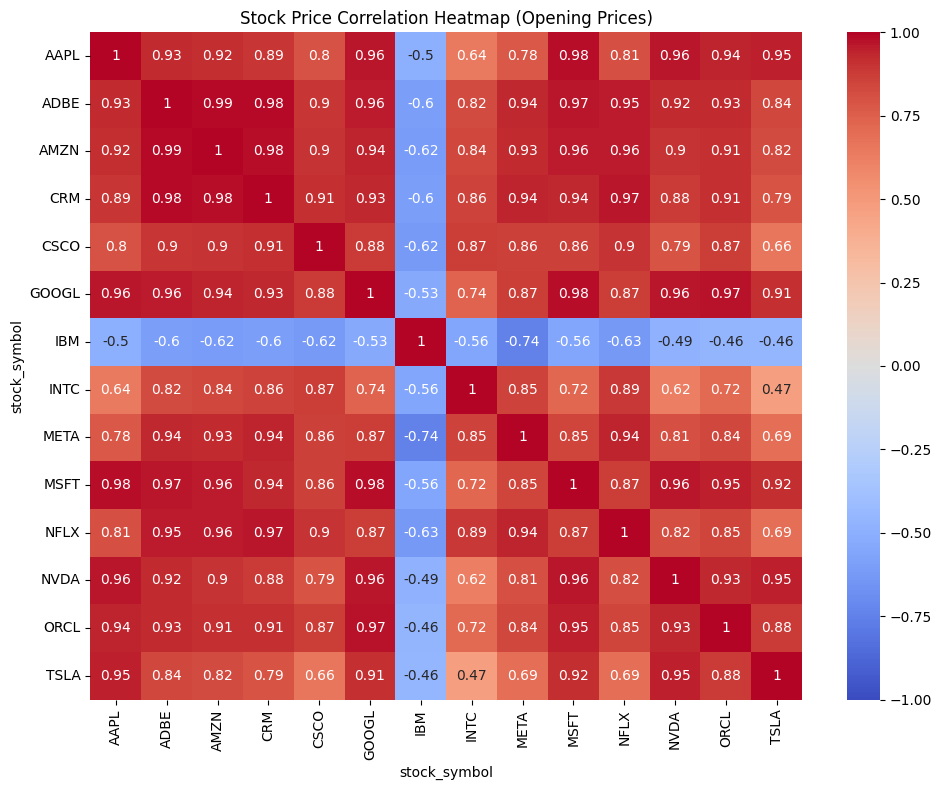

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


folder_path = "data"
stock_prices_df = pd.read_csv(os.path.join(folder_path, "big_tech_stock_prices.csv"))

stock_data = stock_prices_df[['stock_symbol', 'date', 'open']]

# Convert to datetime for proper handling
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Create a pivot table with stocks as columns and dates as index
combined_df = stock_data.pivot_table(index='date', columns='stock_symbol', values='open')

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Stock Price Correlation Heatmap (Opening Prices)")
plt.tight_layout()
plt.show()

In [10]:
combined_df.head()

stock_symbol,AAPL,ADBE,AMZN,CRM,CSCO,GOOGL,IBM,INTC,META,MSFT,NFLX,NVDA,ORCL,TSLA
date,,,,,,,,,,,,,,
2010-01-04,7.622500,36.650002,6.8125,18.652500,24.110001,15.689439,125.411087,20.790001,NaN,30.620001,7.931429,4.6275,24.660000,NaN
2010-01-05,7.664286,37.040001,6.6715,18.612499,24.600000,15.695195,125.889099,20.940001,NaN,30.850000,7.652857,4.6050,24.719999,NaN
2010-01-06,7.656429,37.330002,6.7300,18.687500,24.540001,15.662162,124.933075,20.809999,NaN,30.879999,7.361429,4.6875,24.770000,NaN
2010-01-07,7.562500,37.410000,6.6005,18.629999,24.299999,15.250250,124.158699,20.730000,NaN,30.629999,7.731429,4.6950,24.459999,NaN
2010-01-08,7.510714,36.750000,6.5280,18.517500,24.379999,14.814815,123.393883,20.540001,NaN,30.280001,7.498571,4.5900,24.280001,NaN
